In [1]:
import sys

In [2]:
sys.path.append('..')

In [3]:
from nbhd import data

In [4]:
db = data.Base()

Initializing database connection...
Database connected!


In [5]:
import geopandas as gpd

In [6]:
from shapely.geometry import (MultiPolygon, MultiLineString, 
                                Polygon, LineString)

In [7]:
from shapely.ops import polygonize, unary_union

In [8]:
britain = db.query('SELECT * FROM isles LIMIT 1', spatial=True).iloc[0]

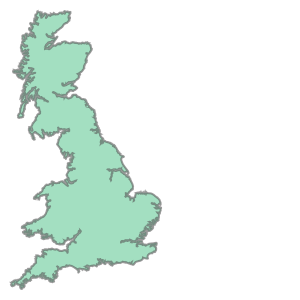

In [9]:
britain.geometry

In [10]:
def round_10k(x, up=False):
    x_round = x // (10**4) * (10**4)
    if up:
        x_round += 10**4
    return x_round

In [11]:
def pixelate(bbox, resolution=10000):
    v_lines = MultiLineString([LineString([(x0+resolution*i,y0),(x0+resolution*i,y1)]) for i in range(int((x1-x0)/resolution))])
    h_lines = MultiLineString([LineString([(x0,y0+resolution*i),(x1,y0+resolution*i)]) for i in range(int((y1-y0)/resolution))])
    return v_lines, h_lines
    

In [12]:
x0, y0, x1, y1 = [round_10k(x, i//2) for i, x 
                  in enumerate(britain.geometry.convex_hull.bounds)]

In [13]:
bbox = Polygon([(x0,y0), (x0,y1), (x1,y1), (x1,y0), (x0,y0)])

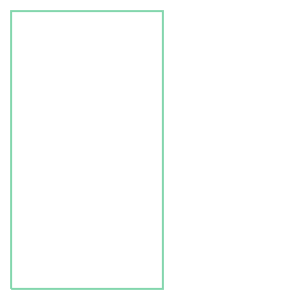

In [14]:
bbox.boundary

In [15]:
v,h = pixelate(bbox)

In [16]:
len(v)

53

In [17]:
len(h)

97

In [18]:
list_pixels = list(polygonize(unary_union([v,h,bbox.boundary])))

In [19]:
pixels_gdf = gpd.GeoDataFrame(geometry=list_pixels, crs=27700)

In [20]:
pixels_gdf.to_postgis('pixels', db.engine, if_exists='replace')

In [21]:
british_pixels = db.intersects('pixels', britain.geometry)

In [22]:
british_pixels.to_postgis('pixels', db.engine, if_exists='replace')

<AxesSubplot:>

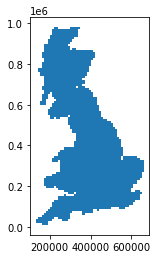

In [23]:
british_pixels.plot()

In [24]:
import matplotlib.pyplot as plt

<AxesSubplot:>

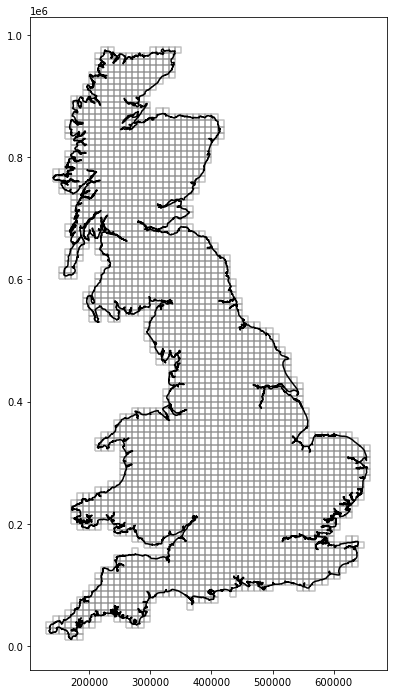

In [25]:
fig, ax = plt.subplots(figsize=(12,12))
british_pixels.boundary.plot(ax=ax, color='grey', alpha=0.5)
gpd.GeoSeries(britain.geometry).boundary.plot(ax=ax, color='k')